In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [ ]:
with open("t8.shakespeare.txt", "r") as f:
    doc = ""
    for line in f.readlines():
        doc += line

In [ ]:
doc = doc[10520:]

In [ ]:
print(len(doc))
regex = r"\s+<<[\s\d\-\(\)A-Z_\.,:@;!\"\']+>>\s+"
result = re.sub(regex, r"", doc, 0, re.MULTILINE)
regex = r"\s+\*+[\s\d\-\(\)A-Za-z_\.,:@!;\"\']+\*+\s+"
result = re.sub(regex, r"", result, 0, re.MULTILINE)
regex = r"(\s)\s+"
result = re.sub(regex, r"\1", result, 0, re.MULTILINE)
regex = r"\d+"
result = re.sub(regex, "", result, 0, re.MULTILINE)
regex = r'(\w)\1{2,}'
result = re.sub(regex, "", result, 0, re.MULTILINE)

print(len(result))

5447679
4820750


In [ ]:
stopwords_list = stopwords.words('english')

In [ ]:
sentences = sent_tokenize(result)
sentences = [word_tokenize(s.lower()) for s in sentences]
sentences = [[(re.sub(r"[,!:;\?\.\-\[\]\(\)]","",t)) for t in s if t not in ["'d", "'ll", "'s","!",":", "?", ";", ",", ".","[","]","(", "(","'"]+stopwords_list]for s in sentences]

In [ ]:
from collections import Counter
freqs = Counter()
for s in sentences:
  freqs.update(s)
freqs_sorted = sorted(freqs.items(),
                        key=lambda p: (p[1], p[0]),
                        reverse=True)
print(freqs_sorted[:20])
print(freqs_sorted[-10:])

[('thou', 5478), ('thy', 4030), ('shall', 3588), ('thee', 3178), ('lord', 3086), ('king', 3027), ('good', 2796), ('sir', 2757), ('come', 2505), ('let', 2344), ('would', 2291), ('well', 2150), ('love', 2136), ('enter', 2105), ('man', 1981), ('hath', 1939), ('one', 1790), ('upon', 1734), ('go', 1726), ('like', 1702)]
[("'agrippa", 1), ("'aged", 1), ("'after", 1), ("'affected", 1), ("'adieu", 1), ("'accurs'd", 1), ("'accommodated", 1), ("'above", 1), ("'abbominable", 1), ("''godamercy", 1)]


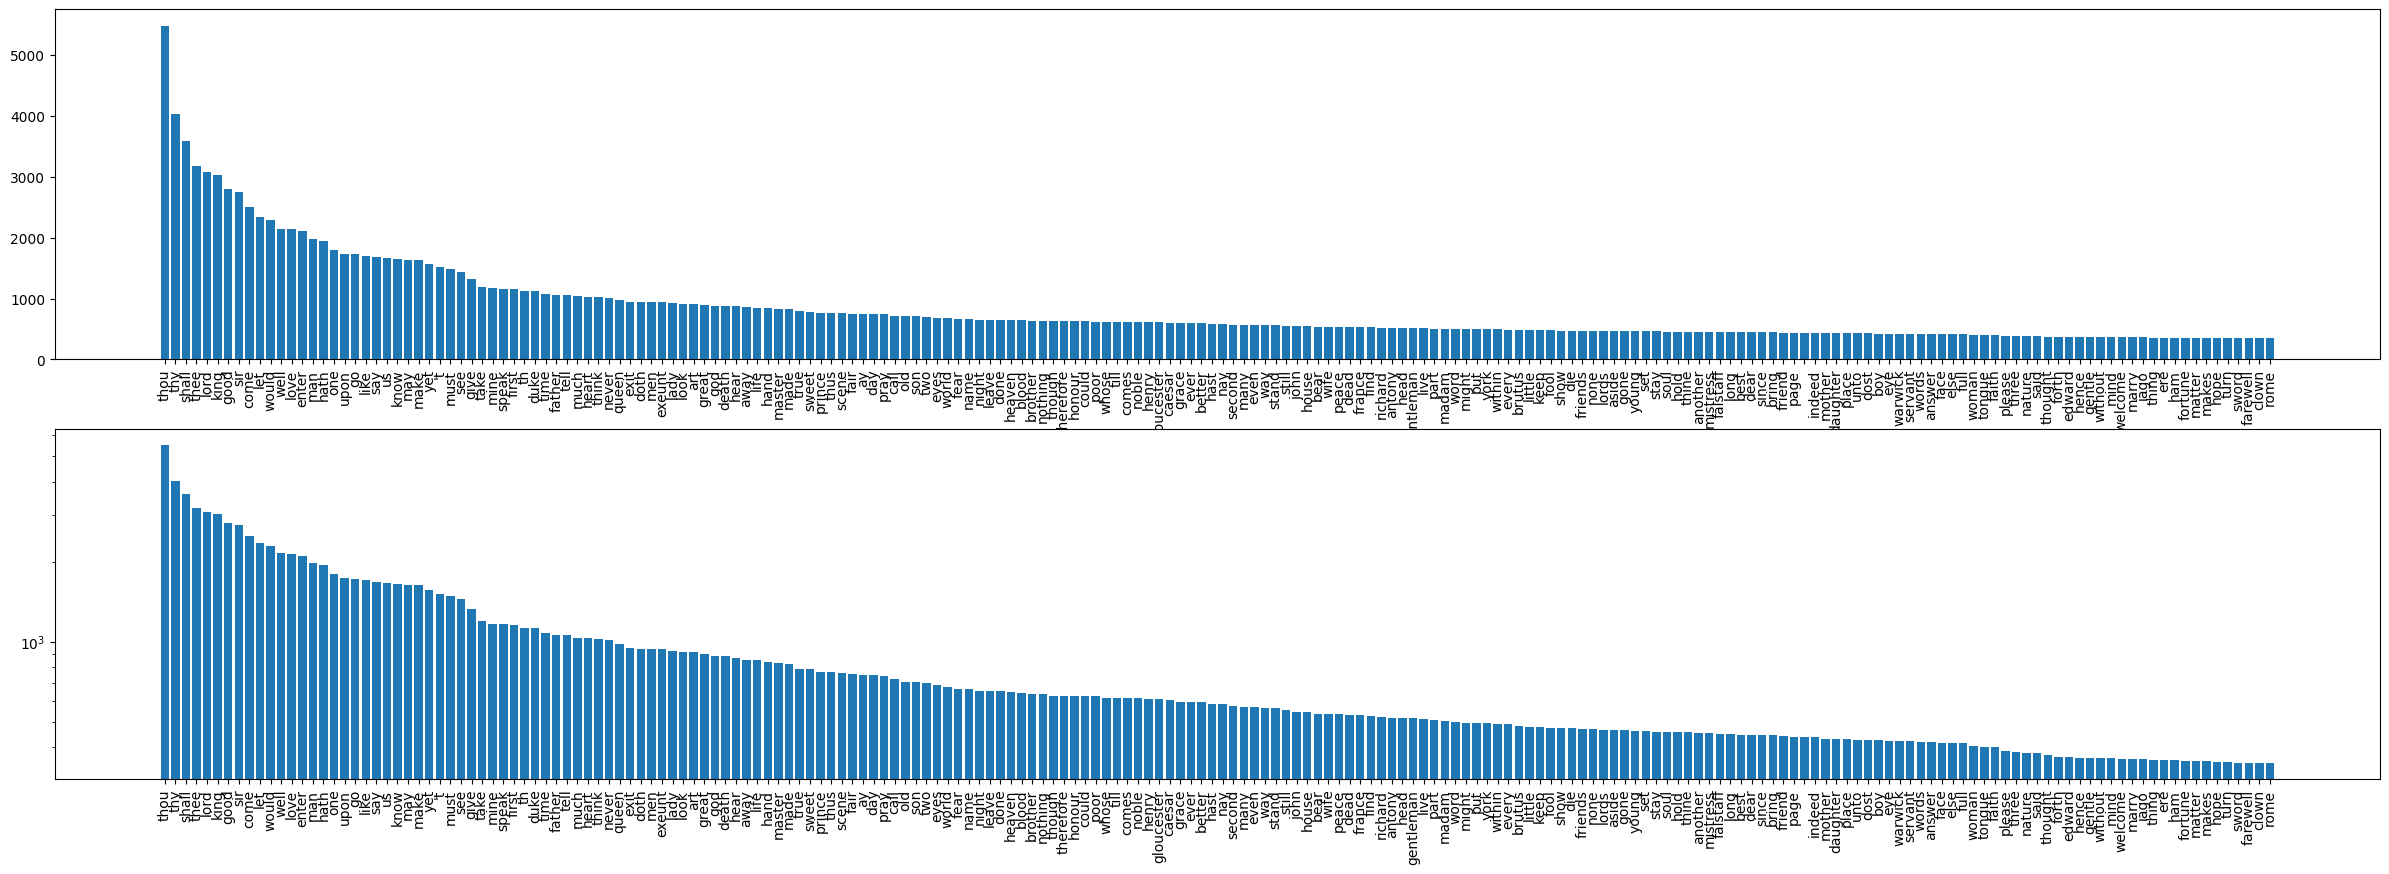

In [ ]:
fig , ax = plt.subplots(nrows=2)
fig.set_figwidth(30)
fig.set_figheight(10)
barplot1 = ax[0].bar([x[0] for x in freqs_sorted[:200]], [x[1] for x in freqs_sorted[:200]])
barplot2 = ax[1].bar([x[0] for x in freqs_sorted[:200]], [x[1] for x in freqs_sorted[:200]], log=True)
for label in ax[0].get_xticklabels():
  label.set_rotation(90)
for label in ax[1].get_xticklabels():
  label.set_rotation(90)

In [ ]:
vocab_size = 23000
sum_freq_pruned = sum(f for _, f in freqs_sorted[vocab_size:])
print(sum_freq_pruned/sum(f for _, f in freqs_sorted)*100)

0.9895637457690861


In [ ]:
freqs_sorted = [("UKN", sum_freq_pruned)] + freqs_sorted[:vocab_size-1]

In [ ]:
ns_table = {}
sum_freq = 0
for w, freq in freqs_sorted:
    ns_freq = freq **  0.75
    ns_table[w] = ns_freq
    sum_freq += ns_freq

scaler = (1<<24) / sum_freq
ns_table = [(w, freq, int(round(ns_table[w]*scaler))) for w, freq in freqs_sorted]

In [ ]:
total_freq = sum(f for _, f, _ in ns_table)
prune_probs = {}
for w, f, _ in ns_table:
    prune_probs[w] = 1 - np.sqrt(1e-5 * total_freq / f)

In [ ]:
voc = { w:i for i, (w, _, _ ) in enumerate(ns_table) }

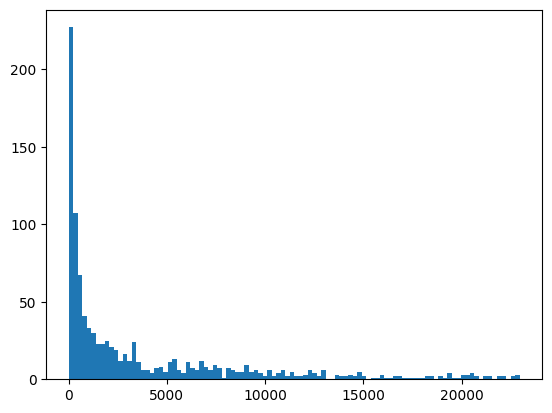

In [ ]:
ns_table_expanded = []
for i, (_, _, count) in enumerate(ns_table):
  ns_table_expanded.extend([i] * count)
neg_ix = np.random.randint(len(ns_table_expanded), size=1000)
_ =plt.hist([ns_table_expanded[k] for k in neg_ix], bins=100)

In [ ]:
ns_table_expanded = []
for i, (_, _, count) in enumerate(ns_table):
  ns_table_expanded.extend([i] * count)
ns_table_expanded = np.array(ns_table_expanded)

In [ ]:
def get_data(batch_size, sentences, window_size, ns_size=5):
  target = []
  context = []
  
  for s in sentences:
    ps = np.random.random(size=len(s))
    #pruned = [w for w, p in zip(s, ps) if p >= prune_probs.get(w, 0)]
    encoded = [voc.get(t, 0) for t in s]
    for i in range(len(encoded)):
      start = max(0, i-window_size)
      end = min(i+window_size+1, len(encoded))
      for j in range(start, end):
        if j != i:
            target.append(encoded[i])
            context.append(np.append( np.array([encoded[j]]), ns_table_expanded[np.random.randint(len(ns_table_expanded), size=ns_size)] ))
        if len(target) == batch_size:
          yield target, context
          target = []
          context = []
  yield target, context

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def log_sigmoid(x):
  return np.log(1/(1+np.exp(-x)))

In [ ]:
def loss(t, c, y, batch_size):
  n_c = np.power(-1, 1-y).reshape(batch_size,1+neg_sample, 1).repeat(embed_size,axis=-1)*c.reshape(batch_size,(1+neg_sample),embed_size)
  return -np.sum(log_sigmoid(np.sum(t.repeat(1+neg_sample, axis=0).reshape(batch_size,(1+neg_sample),embed_size)*n_c,axis=-1)),axis=-1)

In [ ]:
epochs = 10
batch_size = 128
embed_size = 100
neg_sample = 4
lr = 0.001
T = np.random.random(size=(len(ns_table), embed_size))
C = np.random.random(size=(len(ns_table), embed_size)) 

In [ ]:
for i in range(epochs):
  print("epoch {}:".format(i+1), end=" ")
  epoch_loss = 0
  bT = np.copy(T)
  bC = np.copy(C)
  for t, c in tqdm(get_data(batch_size, sentences, 5, neg_sample)):
    epoch_batch_size = len(t)
    y= np.array([[1]+[0]*neg_sample]*epoch_batch_size)
    #if epoch_batch_size == batch_size:
    epoch_loss = (epoch_loss * i + np.mean(loss(T[t], C[c], y, epoch_batch_size)))/(i+1)
    r_c = C[c].reshape(epoch_batch_size,(1+neg_sample),embed_size)
    c_diff = (sigmoid(np.sum(T[t].repeat(1+neg_sample, axis=0).reshape(epoch_batch_size,(1+neg_sample),embed_size)*r_c,axis=-1)) - y).reshape(epoch_batch_size,1+neg_sample,1).repeat(embed_size,axis=-1)*T[t].repeat(1+neg_sample,axis=0).reshape(epoch_batch_size,1+neg_sample,embed_size)
    t_diff = np.sum((sigmoid(np.sum(T[t].repeat(1+neg_sample, axis=0).reshape(epoch_batch_size,(1+neg_sample),embed_size)*r_c,axis=-1)) - y).reshape(epoch_batch_size,1+neg_sample,1).repeat(embed_size,axis=-1)*r_c, axis=1)
    C[c] -= lr*c_diff.reshape(epoch_batch_size,(1+neg_sample),embed_size)
    T[t] -= lr*t_diff
  print("loss: {:.3f}".format(epoch_loss))
  if bLoss < epoch_loss:
    print("early stop")
    T = bT
    C = bC
    break
  bLoss = epoch_loss

epoch 1: 

21190it [01:32, 228.08it/s]


loss: 21.931
epoch 2: 

21190it [01:29, 236.52it/s]


loss: 14.271
epoch 3: 

21190it [01:28, 238.35it/s]


loss: 11.767
epoch 4: 

21190it [01:36, 219.38it/s]


loss: 10.770
epoch 5: 

21190it [01:29, 235.48it/s]


loss: 9.845
epoch 6: 

21190it [01:40, 211.30it/s]


loss: 8.185
epoch 7: 

21190it [01:31, 231.32it/s]


loss: 7.600
epoch 8: 

21190it [01:41, 209.14it/s]


loss: 7.015
epoch 9: 

21190it [01:31, 232.70it/s]


loss: 6.670
epoch 10: 

21190it [02:11, 160.97it/s]

loss: 6.097


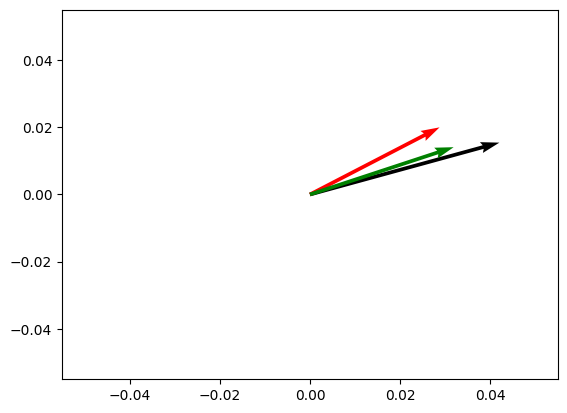

In [ ]:
V = T+C
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=12)
n_V = pca.fit_transform(V)
km = n_V[[voc.get("king", 0)]] - n_V[[voc.get("man", 0)]]
qw = n_V[[voc.get("queen", 0)]] - n_V[[voc.get("woman", 0)]]
bs = n_V[[voc.get("brother", 0)]] - n_V[[voc.get("sister", 0)]]
data = np.array([km[0] , qw[0], bs[0]])
origin = np.array([[0, 0, 0], [0, 0, 0]])
plt.quiver(*origin, data[:, 0], data[:, 1], color=['black', 'red', 'green'], scale=1.5)

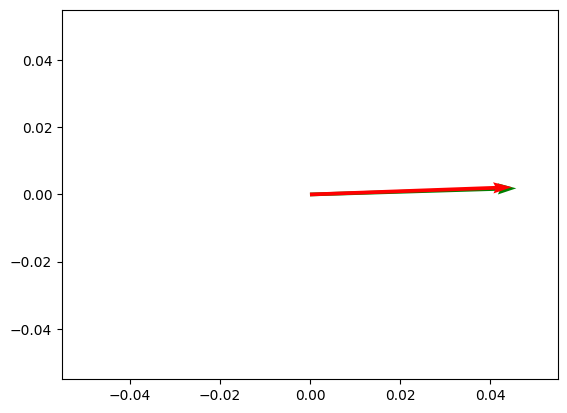

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=12)
n_V = pca.fit_transform(V)
km = n_V[[voc.get("king", 0)]] - n_V[[voc.get("man", 0)]] + n_V[[voc.get("woman", 0)]]
qw = n_V[[voc.get("queen", 0)]]
data = np.array([km[0] , qw[0]])
origin = np.array([[0, 0], [0, 0]])
plt.quiver(*origin, data[:, 0], data[:, 1], color=['green', 'red'], scale=20)